In [3]:
from scipy.io.wavfile import read
import math
import numpy as np

SAMPLING_RATE, audio = read('mhll.wav')
BPM = 60

if len(audio.shape) > 1:
    audio = audio.mean(axis=1)

## Splitting the audio into windows

The audio is split into windows, to increase time resolution of the notes. Due to the Fourier Uncertainty principle there is a trade-off betwen time and frequency resolution. 

time resolution is defined as $$t = \frac{\text{Num Samples per window}}{\text{SAMPLING RATE}}$$
Frequency resolution is defined as $$ f = \frac{\text{SAMPLING RATE}}{\text{Num Samples per window}}$$

Therefore there is an inverse relationship between frequency and time resolution


In [4]:
def getWindow():
    # Convert BPM to approximate number of samples per beat
    interval_seconds = (60 / BPM) / 8 
    #32nd note length
    sample_count = interval_seconds * SAMPLING_RATE
    window = {}
    window["sample_count"] = 3000#sample_count
    window["interval_seconds"]= 0.125 #interval_seconds
    return window

w = getWindow()
time_interval = w["interval_seconds"]

def splitAudio(audio):
    split_audio = {}
    overlap = 0
    start_sample = 0

    # Assuming `w["sample_count"]` and `audio` are properly defined
    sample_count = int(w["sample_count"])

    while start_sample + sample_count <= len(audio): 
        # Slice the segment from the audio
        segment = audio[start_sample : start_sample + sample_count]

        # Create dictionary with time as key
        split_audio[start_sample / SAMPLING_RATE] = segment

        # Move start_sample by overlap
        start_sample = start_sample + int(sample_count * (1 - overlap))
        
        if start_sample + sample_count >= len(audio): 
            segment = audio[start_sample: len(audio)]
            split_audio[start_sample / SAMPLING_RATE] = segment

    return split_audio


In [5]:

split_audio = splitAudio(audio)
print(split_audio)

{0.0: array([0, 0, 0, ..., 3, 8, 9], shape=(3000,), dtype=int16), 0.0625: array([ 1, -2, -1, ...,  4,  9, 11], shape=(3000,), dtype=int16), 0.125: array([  8,  -5, -20, ...,  42,  32,  55], shape=(3000,), dtype=int16), 0.1875: array([77, 75, 62, ..., 11, 24, 31], shape=(3000,), dtype=int16), 0.25: array([ 30,  11,   8, ..., -36, -35, -38], shape=(3000,), dtype=int16), 0.3125: array([-39, -33, -24, ...,  33,  33,  30], shape=(3000,), dtype=int16), 0.375: array([31, 38, 48, ...,  6,  4, -3], shape=(3000,), dtype=int16), 0.4375: array([ -1,   4,  -3, ...,  -3,  -5, -11], shape=(3000,), dtype=int16), 0.5: array([-12,  -8,  -8, ...,  28,  27,  30], shape=(3000,), dtype=int16), 0.5625: array([33, 32, 38, ...,  6,  1, -6], shape=(3000,), dtype=int16), 0.625: array([-16, -24, -30, ..., -62, -68, -73], shape=(3000,), dtype=int16), 0.6875: array([-64, -64, -75, ..., -28, -19, -19], shape=(3000,), dtype=int16), 0.75: array([-20, -15, -14, ...,  18,  14,  24], shape=(3000,), dtype=int16), 0.8125: 

In [6]:
import cmath

In [28]:
def DFT(window): 
    numSamp = len(window)
    DFT_result = {}
    # Loop through frequencies up to Nyquist
    for freq in range(numSamp):
        # Initialize the coefficient for the frequency
        coefficient = 0
        for sample in range(numSamp): 
            # Use cmath.exp for complex exponential
            coefficient += window[sample] * cmath.exp(-2j * cmath.pi * freq / numSamp * sample)
        DFT_result[freq] = coefficient
    return DFT_result

## FFT Algorithm
The FFT algorithm is a variation of the Discrete Fourier Tranform (DFT). It turns the DFTs $O(n^2)$ time into $O(\log_2{n})$.
let the DFT be denoted by 
 $$X[k] = \sum_{n=0}^{N-1} g(n) * e^{\frac{2 \pi i k}{N} } $$

 where k is the frequency, N is the amount of samples, and g(n) is the value of the signal at sample n

 To understand the FFT we realize that X[k] is N-cyclic, meaning for every N the values of X[k] repeat itself: 

let r < k. We will then prove that for $r+ N/2$ X[k] repeats itself: 
then 
$$X[r+\frac{N}{2}] = \sum_{n=0}^{N-1} g(n) * e^{\frac{2 \pi i (r+\frac{N}{2})}{N} } $$

$$X[r+\frac{N}{2}] = e^{i \pi } * \sum_{n=0}^{N-1} g(n) * e^{\frac{2 \pi i r}{N} } = \sum_{n=0}^{N-1} g(n) * e^{\frac{2 \pi i r}{N} } $$ 

The trick of the FFT is that it splits the original sum into smaller sums thereby increasing the amount the sums repeat. This allows computations to be rused making it much faster. 

First the FFT splits the original sum into summations over even and odd samples of the signal

$$X[k] = \textcolor{red}{\sum_{n=0}^{\frac{N}{2}-1} g(2n) * e^{\frac{2 \pi i k (2n)}{N}}} + \textcolor{green}{\sum_{n=0}^{\frac{N}{2}-1} g(2n+1) * e^{\frac{2 \pi i k (2n+1)}{N} }} $$

where the red summation represents <span style="color:red">Even</span> samples and the green represents <span style="color:green">Odd</span>. 

The formula can be rewritten

$$X[k] = \textcolor{red}{\sum_{n=0}^{\frac{N}{2}-1} g(2n) * e^{\frac{4 \pi i k n}{N}}} + \textcolor{green}{\sum_{n=0}^{\frac{N}{2}-1} g(2n+1) * e^{\frac{4 \pi i n k}{N} } e^{\frac{2\pi i k}{N}}} $$

This formula can be further simplified by: 
$e^{\frac{2 \pi i k}{N}} = W_{N}^{k}$

$$X[k] = \textcolor{red}{\sum_{n=0}^{\frac{N}{2}-1} g(2n) * {(W_{N}^{2})}^{kn}} + \textcolor{green}{ {(W_{N}^{k})}^n \sum_{n=0}^{\frac{N}{2}-1} g(2n+1) * {(W_{N}^{2})}^{nk} } $$






## FFT code

In [7]:
signal = [0,1,2,3,4,5,6,7]
frequency_resolution = 1/w["interval_seconds"]


# def fft(signal):
#     q = [0] * 2**int(math.ceil(math.log2(len(signal))))
#     for i in range(len(signal)):
#         q[i] = signal[i]
        
#     N = len(q)
#     if N == 1:
#         return q

#     even_samples = fft(q[::2])
#     odd_samples = fft(q[1::2])

#     amps = [0] * N
#     frequencies = [0] * N
#     for k in range(N // 2):
#         omega_times_odd = cmath.exp(-2j * cmath.pi * k / N) * odd_samples[k]
#         amps[k] = even_samples[k] + omega_times_odd
#         amps[k + N // 2] = even_samples[k] - omega_times_odd
#         frequencies[k] = k*frequency_resolution
#     return frequencies, amps

def fft(signal):
    # Zero-pad to the next power of 2
    q = [0] * 2**int(math.ceil(math.log2(len(signal))))
    for i in range(len(signal)):
        q[i] = signal[i]

    N = len(q)
    if N == 1:
        return q  # Base case: Return the signal itself (complex value)

    # Split into even and odd samples
    even_samples = fft(q[::2])
    odd_samples = fft(q[1::2])
    
    amps = [0.0 + 0.0j] * N
    for k in range(N // 2):
        omega_times_odd = cmath.exp(-2j * cmath.pi * k / N) * odd_samples[k]
        amps[k] = even_samples[k] + omega_times_odd
        amps[k + N // 2] = even_samples[k] - omega_times_odd

    return amps  # Only return the amplitudes (no frequencies)

def get_frequencies(sampling_rate, amps):
    N = len(amps)
    frequency_resolution = sampling_rate / N
    return [k * frequency_resolution for k in range(N // 2)]
    # freq_and_amp = {}
    # for index, freq in enumerate(frequencies):
    #     freq_and_amp[freq] = amps[index]
    # return freq_and_amp
        

test = splitAudio(audio)[0]
amps = fft(signal)
print("amp: ", amps)
print("/n")
print("freq + amps: ", get_frequencies(8, amps))

amp:  [(28+0j), (-4+9.65685424949238j), (-4+4j), (-4+1.6568542494923797j), (-4+0j), (-3.9999999999999996-1.6568542494923797j), (-3.9999999999999996-4j), (-3.9999999999999987-9.65685424949238j)]
/n
freq + amps:  [0.0, 1.0, 2.0, 3.0]


# CUSTOM rendering


In [8]:
           
def findDistance(note1, note2): 
    distance = 0
    #*not accounting for # or flats
    n1_letter_val  = ord(note1[0])
    n1_octave  = int(note1[1])
    n2_letter_val  = ord(note2[0])
    n2_octave  = int(note2[1])
    
    distance = np.abs(n1_letter_val - n2_letter_val) + 8 * np.abs(n1_octave - n2_octave)
    
    
    # print("Letter B: ", n1_letter_val, " Octave: ", n1_octave)
    # print("Letter C: ", n2_letter_val, " Octave: ", n2_octave)
    # print("Distance: ", distance)
    return distance

def findClef(score): 
    clefs = {
        "treble": "B5",
        "bass": "D3",
        "alto": "C4"
    }
    measure = 0
    min = 9999999999999
    closestClef = ""
    for clef in clefs: 
        middlenote = clefs[clef]
        for data in score:
            distance = findDistance(data[1], middlenote)
            #* emphasize close notes more
            measure += math.exp(distance)
        
        if measure <= min: 
            min = measure
            closestClef = clef
    return closestClef


def findKeySignature(score): 
    keySignatures = { 
        # Key Signatures in the Treble Clef
        "C Major": ["C", "D", "E", "F", "G", "A", "B"],  # No sharps or flats
        "G Major": ["G", "A", "B", "C", "D", "E", "F#"],  # One sharp (F#)
        "D Major": ["D", "E", "F#", "G", "A", "B", "C#"],  # Two sharps (F#, C#)
        "A Major": ["A", "B", "C#", "D", "E", "F#", "G#"],  # Three sharps (F#, C#, G#)
        "E Major": ["E", "F#", "G#", "A", "B", "C#", "D#"],  # Four sharps (F#, C#, G#, D#)
        "B Major": ["B", "C#", "D#", "E", "F#", "G#", "A#"],  # Five sharps (F#, C#, G#, D#, A#)
        "F# Major": ["F#", "G#", "A#", "B", "C#", "D#", "E#"],  # Six sharps (F#, C#, G#, D#, A#, E#)
        "C# Major": ["C#", "D#", "E#", "F#", "G#", "A#", "B#"],  # Seven sharps (F#, C#, G#, D#, A#, E#, B#)
        "F Major": ["F", "G", "A", "Bb", "C", "D", "E"],  # One flat (Bb)
        "Bb Major": ["Bb", "C", "D", "Eb", "F", "G", "A"],  # Two flats (Bb, Eb)
        "Eb Major": ["Eb", "F", "G", "Ab", "Bb", "C", "D"],  # Three flats (Bb, Eb, Ab)
        "Ab Major": ["Ab", "Bb", "C", "Db", "Eb", "F", "G"],  # Four flats (Bb, Eb, Ab, Db)
        "Db Major": ["Db", "Eb", "F", "Gb", "Ab", "Bb", "C"],  # Five flats (Bb, Eb, Ab, Db, Gb)
        "Gb Major": ["Gb", "Ab", "Bb", "Cb", "Db", "Eb", "F"],  # Six flats (Bb, Eb, Ab, Db, Gb, Cb)
        "Cb Major": ["Cb", "Db", "Eb", "Fb", "Gb", "Ab", "Bb"],  # Seven flats (Bb, Eb, Ab, Db, Gb, Cb, Fb
                     }
    
    for key_sig in keySignatures:
        count = 0
        min = 999
        bestKey = ""
        for data in score: 
            note = data[1]
            note_name = note[0]
            #print(note_name)
            if note_name not in keySignatures[key_sig]: 
                count += 1 
        if count <= min: 
            bestKey = key_sig
        
    return bestKey
                                                                                                         
print("Closest Clef: ", findClef(score))
print("Key Signature: ", findKeySignature())

NameError: name 'score' is not defined

In [9]:

import os

oct4notes = { 
             "D4": 293,
             "E4": 329,
             "C4": 261,
             "G4": 392
             }

def comparenotes(frequency): 
    min = 999
    currnote = ""
    for note in oct4notes: 
        if abs(frequency - oct4notes[note]) <= min: 
            min = abs(frequency - oct4notes[note])
            currnote = note
    return currnote


def stft(signal,threshold): 
    notes = []
    split_signal = splitAudio(signal)
    for time_key in split_signal: 
        
        amps = fft(split_signal[time_key])
        positiveFreq_amps = [amps[k] for k in range(len(amps) // 2)] #gets frist half of amps corresponding to positive frequencies
        frequencies = get_frequencies(SAMPLING_RATE, amps)
        top_index = np.argsort(positiveFreq_amps)[-1]

        for k in range(len(positiveFreq_amps)): 
            positiveFreq_amps[k] = positiveFreq_amps[k] / 5864 #scales all amplitudes between 0 and 4000

        if positiveFreq_amps[top_index] < threshold:
            notes.append("rest")  
        else:
            #complicated dictionary way to get top frequency from top amplitude index 
            #top_freq = list(freqs_and_amps.keys())[list(freqs_and_amps.values()).index(top_index)]
            top_freq = frequencies[top_index]
            notes.append(comparenotes(top_freq))
    return notes

print(stft(audio,30))

['rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'G4', 'E4', 'E4', 'E4', 'E4', 'E4', 'D4', 'D4', 'D4', 'D4', 'D4', 'rest', 'C4', 'C4', 'C4', 'D4', 'rest', 'D4', 'D4', 'D4', 'D4', 'D4', 'D4', 'E4', 'D4', 'E4', 'E4', 'E4', 'rest', 'C4', 'E4', 'E4', 'G4', 'E4', 'rest', 'E4', 'E4', 'E4', 'E4', 'E4', 'E4', 'G4', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'D4', 'D4', 'D4', 'D4', 'D4', 'rest', 'D4', 'D4', 'D4', 'D4', 'D4', 'rest', 'D4', 'D4', 'D4', 'D4', 'D4', 'D4', 'D4', 'D4', 'rest', 'rest', 'rest', 'rest', 'E4', 'D4', 'E4', 'E4', 'E4', 'G4', 'G4', 'G4', 'G4', 'G4', 'rest', 'G4', 'G4', 'G4', 'G4', 'G4', 'G4', 'G4', 'G4', 'G4', 'rest', 'rest', 'G4', 'E4', 'E4', 'E4', 'E4', 'rest', 'E4', 'D4', 'D4', 'D4', 'D4', 'D4', 'C4', 'C4', 'C4', 'C4', 'rest', 'C4', 'D4', 'C4', 'D4', 'E4', 'rest', 'D4', 'rest', 'E4', 'E4', 'E4', 'G4', 'rest', 'rest', 'E4', 'E4', 'E4', 'E4', 'E4', '

In [10]:
import pygame
import os
import math
import numpy as np

# Change the working directory to the correct path
os.chdir('/Users/charleskim/FourierMusicTranscription/Rendering')



####STUFFF 
clefs = {
        "treble": "B5",
        "bass": "D3",
        "alto": "C4"
    }
           
def findDistance(note1, note2): 
    distance = 0
    #*not accounting for # or flats
    n1_letter_val  = ord(note1[0])
    n1_octave  = int(note1[1])
    n2_letter_val  = ord(note2[0])
    n2_octave  = int(note2[1])

    # print(f"Note 1 letter: {note1[0]}, Value: ", n1_letter_val, " Octave: ", n1_octave)
    # print(f"Note 2 letter: {note2[0]}, Value: ", n2_letter_val, " Octave: ", n2_octave)
    
    distance = n1_letter_val - n2_letter_val + 8 * (n1_octave - n2_octave)
    #print(f"Distance between {note1} and {note2} = ", distance)
    
    
    # print("Letter B: ", n1_letter_val, " Octave: ", n1_octave)
    # print("Letter C: ", n2_letter_val, " Octave: ", n2_octave)
    # print("Distance: ", distance)
    return distance

def findClef(score): 
    measure = 0
    min = 9999999999999
    closestClef = ""
    for clef in clefs: 
        middlenote = clefs[clef]
        print("Middle Note: ", middlenote)
        measure = 0 
        for data in score:
            difference = findDistance(data[0], middlenote)
            
            #* emphasize close notes more
            measure += difference ** 2
            #print("Measure: ", measure)
        if measure <= min: 
            min = measure
            closestClef = clef
        
    return closestClef

#CLEF = findClef(score)


def findKeySignature(score): 
    keySignatures = { 
        # Key Signatures in the Treble Clef
        "C Major": ["C", "D", "E", "F", "G", "A", "B"],  # No sharps or flats
        "G Major": ["G", "A", "B", "C", "D", "E", "F#"],  # One sharp (F#)
        "D Major": ["D", "E", "F#", "G", "A", "B", "C#"],  # Two sharps (F#, C#)
        "A Major": ["A", "B", "C#", "D", "E", "F#", "G#"],  # Three sharps (F#, C#, G#)
        "E Major": ["E", "F#", "G#", "A", "B", "C#", "D#"],  # Four sharps (F#, C#, G#, D#)
        "B Major": ["B", "C#", "D#", "E", "F#", "G#", "A#"],  # Five sharps (F#, C#, G#, D#, A#)
        "F# Major": ["F#", "G#", "A#", "B", "C#", "D#", "E#"],  # Six sharps (F#, C#, G#, D#, A#, E#)
        "C# Major": ["C#", "D#", "E#", "F#", "G#", "A#", "B#"],  # Seven sharps (F#, C#, G#, D#, A#, E#, B#)
        "F Major": ["F", "G", "A", "Bb", "C", "D", "E"],  # One flat (Bb)
        "Bb Major": ["Bb", "C", "D", "Eb", "F", "G", "A"],  # Two flats (Bb, Eb)
        "Eb Major": ["Eb", "F", "G", "Ab", "Bb", "C", "D"],  # Three flats (Bb, Eb, Ab)
        "Ab Major": ["Ab", "Bb", "C", "Db", "Eb", "F", "G"],  # Four flats (Bb, Eb, Ab, Db)
        "Db Major": ["Db", "Eb", "F", "Gb", "Ab", "Bb", "C"],  # Five flats (Bb, Eb, Ab, Db, Gb)
        "Gb Major": ["Gb", "Ab", "Bb", "Cb", "Db", "Eb", "F"],  # Six flats (Bb, Eb, Ab, Db, Gb, Cb)
        "Cb Major": ["Cb", "Db", "Eb", "Fb", "Gb", "Ab", "Bb"],  # Seven flats (Bb, Eb, Ab, Db, Gb, Cb, Fb
                     }
    
    for key_sig in keySignatures:
        count = 0
        min = 999
        bestKey = ""
        for data in score: 
            note = data[0]
            note_name = note[0] #cuts out octave 
            #print(note_name)
            if note_name not in keySignatures[key_sig]: 
                count += 1 
        if count <= min: 
            bestKey = key_sig
        
    return bestKey
                                                                                                         
# print("Closest Clef: ", findClef(score))
#print("Key Signature: ", findKeySignature())

BPM =60
# def get_duration(count): 
#     min = 10
#     closestnote = ""
#     durations = {}
#     time = count * w["interval_seconds"]
#     whole] = 60/BPM * 4
#     # half] = durations["whole"] /2 
#     durations[quarter] = durations[whole]/4
#     durations[eighth] = durations[whole]/8
#     durations[sixteenth] = durations[whole]/16
#     durations[thirtysecond] = durations[whole]/32
#     #durations["sixtyfourth"] = durations["whole"]/64
#     for length in durations: 
#         if abs(time-durations[length]) < min:
#             closestnote = length
#             min = abs(time-durations[length])
#     return closestnote

def get_duration(count): 
    min = 10
    closestnote = ""
    durations = {}
    time = count * w["interval_seconds"]
    durations["whole"] = 60/BPM * 4
    #durations[half] = durations["whole"] /2 
    durations["quarter"] = durations["whole"]/4
    durations["eighth"] = durations["whole"]/8
    durations["sixteenth"] = durations["whole"]/16
    durations["thirtysecond"] = durations["whole"]/32
    #durations["sixtyfourth"] = durations["whole"]/64
    for length in durations: 
        if abs(time-durations[length]) < min:
            closestnote = length
            min = abs(time-durations[length])
    return closestnote

def makeScore(notes): 
    score = []
    count = 0 
    for note_index in range(len(notes)): 
        if note_index == len(notes) - 1:
            continue
        cur_note = notes[note_index]
        next_note = notes[note_index + 1]
        if cur_note == next_note:
            count += 1
        else: 
            score.append((cur_note, get_duration(count)))
            count = 0
        
        for data in score: 
            note = data[0]
            if note == '': 
                count += 1
                score.remove(data)
    print("COUNT OF mess up notes: ", count)    
    return score

score = makeScore(stft(audio,60))
print(score)



def getNoteCoords(score): 
    positions = []
    horizontal_position = 0
    screen_length = 800
    for data in score:
        note = data[0]
        if note == "rest":
            pass
        else:
            vert_position = -10 - 5 * findDistance(note, clefs[CLEF])
            positions.append((horizontal_position, vert_position))
            horizontal_position += 15
            #wraps  around
            if horizontal_position >= screen_length: 
                horizontal_position = 0
                vert_position += 60
    return positions
        
    
def renderStaff():
    screen.blit(staff, (0, -300))
    screen.blit(staff, (0, -240))
    screen.blit(staff, (0, -180))
    screen.blit(staff, (0, -120))
    screen.blit(staff, (0, -60))
    screen.blit(staff, (0, 0))
    screen.blit(staff, (0, 60))
    screen.blit(staff, (0, 120))



# def renderNote(score): 
#     positions = getNoteCoords(score)
#     for n in  range(len(positions)):
#         note_duration = score[n][1]
#         screen.blit(note_duration, positions[n])

def renderNote(score): 
    positions = getNoteCoords(score)
    for n in  range(len(positions)):
        note_duration = score[n][1]
        if note_duration == "whole":
            screen.blit(whole, positions[n])
        elif note_duration == "quarter":
            screen.blit(quarter, positions[n])
        elif note_duration == "eighth":
            screen.blit(eighth, positions[n])
        elif note_duration == "sixteenth":
            screen.blit(sixteenth, positions[n])
        elif note_duration == "thirtysecond":
            screen.blit(thirtysecond, positions[n])
        #screen.blit(note_duration, positions[n])
        

########PYGAME RUNNER

pygame.init()
SCREEN_WIDTH = 800
SCREEN_HEIGHT = 600

screen = pygame.display.set_mode((SCREEN_WIDTH, SCREEN_HEIGHT))

pygame.display.set_caption('Pygame Image Rendering')
run = True
DEFAULT_NOTE_SIZE = (100, 100)
whole = pygame.image.load('whole.png')
quarter = pygame.image.load('quarter.png')
eighth = pygame.image.load('eighth.png')
sixteenth = pygame.image.load('16th.png')
thirtysecond = pygame.image.load('32nd.png')
staff = pygame.image.load('staff.png')
score = [("C4",eighth),("C4",thirtysecond),("A4",eighth),("C4",whole),("C4",eighth),("C4",eighth),("C4",eighth)]


# Scale the image to 50x50 pixels
whole = pygame.transform.scale(whole, DEFAULT_NOTE_SIZE)

quarter = pygame.transform.scale(quarter, DEFAULT_NOTE_SIZE)  # Scale the image to 50x50 pixels
eighth = pygame.transform.scale(eighth, DEFAULT_NOTE_SIZE)
sixteenth = pygame.transform.scale(sixteenth, DEFAULT_NOTE_SIZE)
thirtysecond = pygame.transform.scale(sixteenth, DEFAULT_NOTE_SIZE)

staff = pygame.transform.scale(staff, (800, 800))
CLEF = findClef(score)

    # screen.fill((255, 255, 255))
    # screen.blit(quarter, (0, -10))
    # screen.blit(eighth, (10, 0))
    # screen.blit(sixteenth, (20, 0))
    # screen.blit(whole, (30, 0))
    
for event in pygame.event.get():
    if event.type == pygame.QUIT:
        #run = False
        pygame.quit()
screen.fill((255, 255, 255))
renderStaff()
renderNote(score)
pygame.display.update() 
    
#pygame.quit()

COUNT OF mess up notes:  22
[('rest', 'quarter'), ('G4', 'thirtysecond'), ('E4', 'eighth'), ('D4', 'eighth'), ('rest', 'thirtysecond'), ('C4', 'sixteenth'), ('D4', 'thirtysecond'), ('rest', 'thirtysecond'), ('D4', 'eighth'), ('E4', 'thirtysecond'), ('D4', 'thirtysecond'), ('E4', 'sixteenth'), ('rest', 'thirtysecond'), ('E4', 'thirtysecond'), ('rest', 'thirtysecond'), ('E4', 'thirtysecond'), ('rest', 'thirtysecond'), ('E4', 'eighth'), ('rest', 'quarter'), ('D4', 'eighth'), ('rest', 'thirtysecond'), ('D4', 'eighth'), ('rest', 'thirtysecond'), ('D4', 'quarter'), ('rest', 'eighth'), ('E4', 'thirtysecond'), ('D4', 'thirtysecond'), ('E4', 'sixteenth'), ('rest', 'thirtysecond'), ('G4', 'thirtysecond'), ('rest', 'thirtysecond'), ('G4', 'thirtysecond'), ('rest', 'thirtysecond'), ('G4', 'eighth'), ('rest', 'eighth'), ('E4', 'eighth'), ('rest', 'thirtysecond'), ('E4', 'thirtysecond'), ('D4', 'eighth'), ('C4', 'eighth'), ('rest', 'thirtysecond'), ('C4', 'thirtysecond'), ('D4', 'thirtysecond'), ('C

2024-12-26 22:06:45.169 Python[60876:4341245] +[IMKClient subclass]: chose IMKClient_Modern
2024-12-26 22:06:45.169 Python[60876:4341245] +[IMKInputSession subclass]: chose IMKInputSession_Modern


[np.float64(559.8962547178909), np.float64(1200.837023841345), np.float64(1038.9789461865428), np.float64(955.4939424062786), np.float64(952.0916670635647), np.float64(838.7870542743673), np.float64(1372.2194379233815), np.float64(1090.231583026397), np.float64(776.7958046240336), np.float64(670.5730696285482), np.float64(520.0021051684542), np.float64(737.0274951644298), np.float64(1481.748805209459), np.float64(1060.6617541679584), np.float64(868.6858087641144), np.float64(652.601725310657), np.float64(349.8057629789823), np.float64(296.87096969285244), np.float64(366.2721923961192), np.float64(193.3584152458824), np.float64(174.79874525602577), np.float64(199.6692484933167), np.float64(239.7882574464485), np.float64(426.23750556953354), np.float64(318.94355787158304), np.float64(248.0217868035613), np.float64(224.05806239276114), np.float64(219.50846362457696), np.float64(187.30396914295756), np.float64(174.4200086895143), np.float64(179.68666621399424), np.float64(174.8534062789980

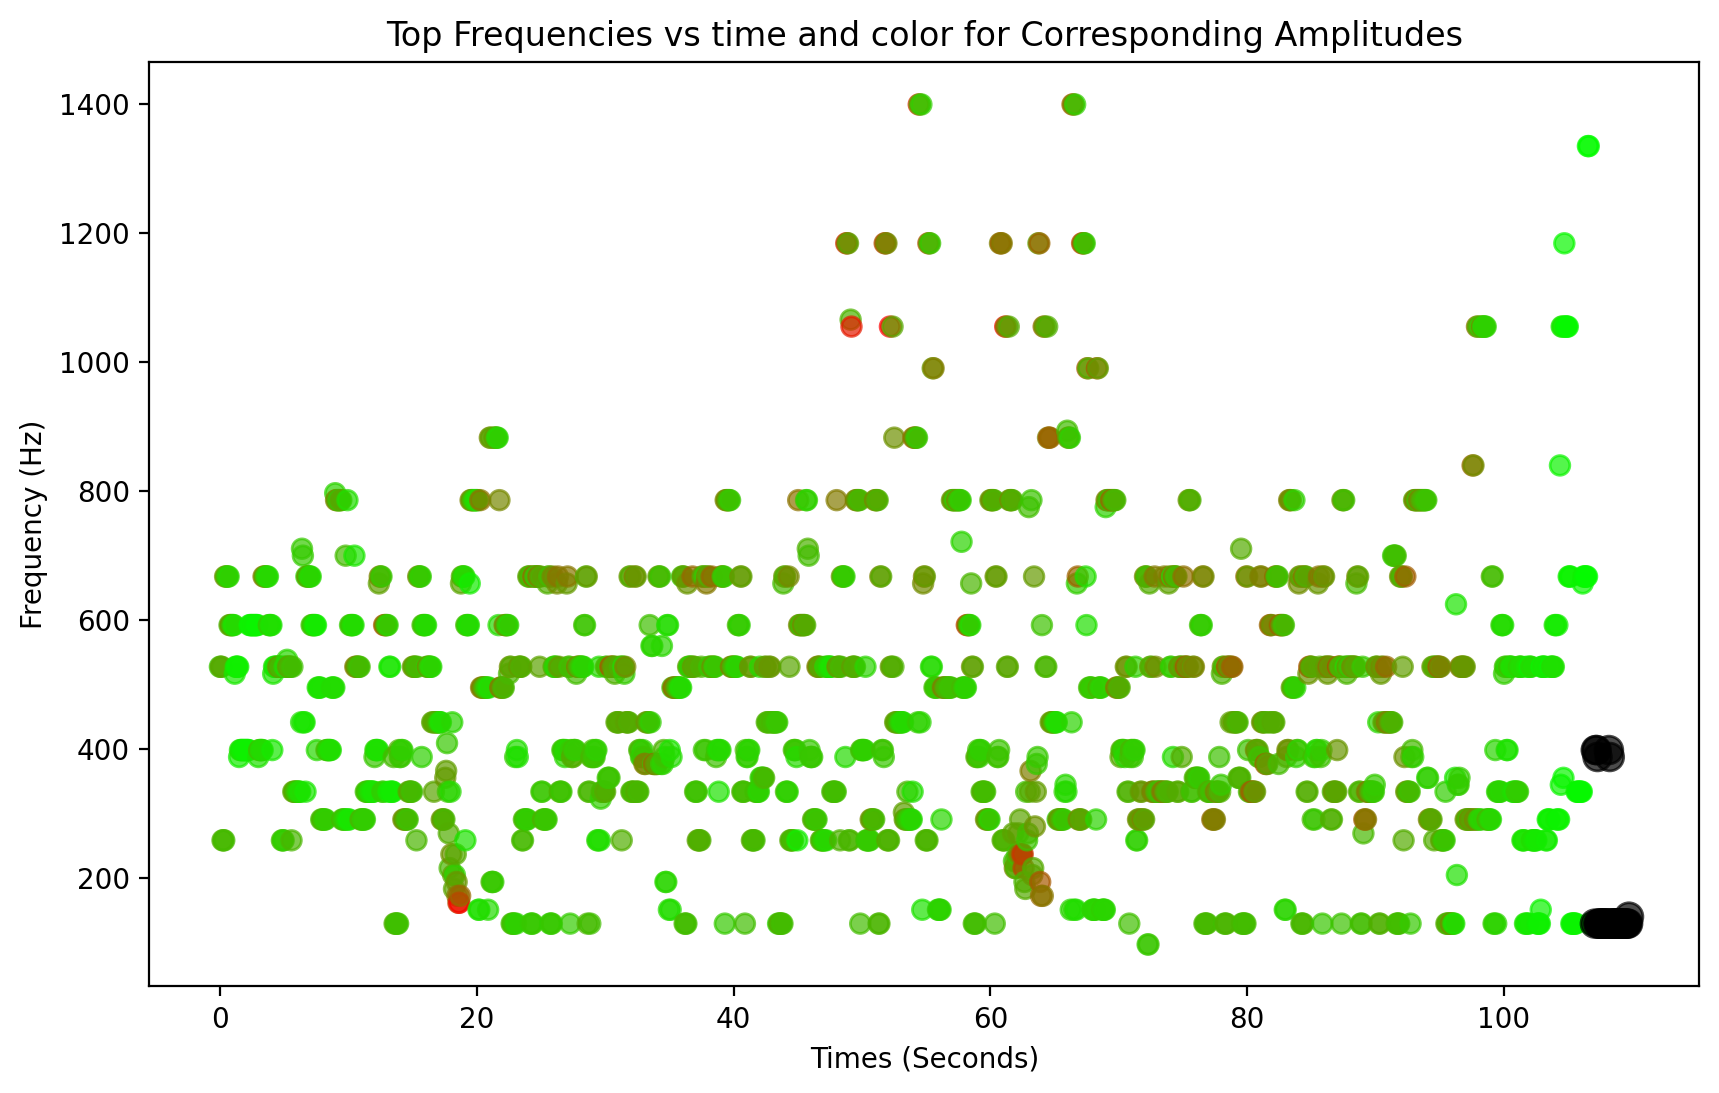

In [42]:
import matplotlib.pyplot as plt
import numpy as np  

def visualize(signal,threshold): 
    notes = []
    all_top_freqs = []
    all_top_amps = []
    times = []

    split_signal = splitAudio(signal)
    for time_key in split_signal: 
        
        amps = np.abs(fft(split_signal[time_key]))
        for k in range(len(amps)): 
            amps[k] = amps[k] / 5864 #scales all amplitudes between 0 and 4000
        positiveFreq_amps = [amps[k] for k in range(len(amps) // 2)] #gets frist half of amps corresponding to positive frequencies
        frequencies = get_frequencies(SAMPLING_RATE, amps)
        top_index = np.argsort(positiveFreq_amps)[-1]
        #add top freq and amps to their lists
        all_top_freqs.append(frequencies[top_index])
        all_top_amps.append(positiveFreq_amps[top_index]) 
        times.append(float(time_key))  

    print(all_top_amps)
    print("times: ", times) 
    #print("\n Top amp: ", max(all_top_amps))
    colors = [
        'black' if amp < threshold else (amp / max(all_top_amps), 1 - amp / max(all_top_amps), 0)
        for amp in all_top_amps
    ]
    sizes = [100 if amp < threshold else 50 for amp in all_top_amps]   

    plt.figure(figsize=(10, 6))
    plt.scatter(times, all_top_freqs, c=colors, s=sizes, alpha=0.7)
    plt.title('Top Frequencies vs time and color for Corresponding Amplitudes')
    plt.xlabel('Times (Seconds)')
    plt.ylabel('Frequency (Hz)')
    plt.show() 
visualize(audio,30)
            

In [43]:
LEVEL =0 
twiddles = {}
signal = [0,1,2,3,4,5,6,7]
N = len(signal)
#intialize 
for sample in signal: 
    twiddles[sample] = 1
    
def getTwiddles(level, *args): 
    if len(even ) == 1: 
            return
    for list in args: 
        even = list[::2]
        odd = list[1::2]
        level += 1
        for sample in odd: 
            twiddles[sample] *= cmath.exp((-1j * cmath.pi  * 2 * level)/N)
        
        
        getTwiddles(level, even, odd)
        
def computeFFT(): 
    frequencyBins = {}
    for frequency in range(N): 
        sum = 0
        frequencyBins[frequency] = 0
        for sample in range(N): 
            frequencyBins[frequency] += signal[sample] * twiddles[sample]**frequency
    
    return frequencyBins
        
getTwiddles(LEVEL,signal)   
print(twiddles)

for freq in computeFFT(): 
    print("Frequency bin: ", freq, "value: ", computeFFT()[freq])
    
print(DFT(signal))
    

UnboundLocalError: cannot access local variable 'even' where it is not associated with a value